In [1]:
import numpy as np
import xsimlab as xs
#from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]

# A simple phytoplankton chemostat model

Phytoplankton are microscopic autotrophic organisms, that form the basis of the oceanic food web.

A chemostat is a simple flow-through system often used in labs for phytoplankton growth experiments. A population of phytoplankton is inoculated in a bottle, where a constant inflow of nutrients (e.g. nitrate) supports their growth. As the volume is kept constant, what flows in must flow out, so a fraction of the volume containing both nutrients and phytoplankton is lost from the system continously. The balance of nutrient supply, phytoplankton mortality and growth, as well as flow rate defines the trajectory of the system. Too fast flow rates dilute the phytoplankton population out of existence, whilst with smaller flow rates nutrients are quickly used up. The model is very likely to reach a steady-state. 

Below is a basic model implementation of such a system, with the added functionality, that it allows for a flexible number of phytoplankton state variables to be defined. In theory this can represent a diverse phytoplankton community. 

The model is written in the object-oriented xarray-simlab framework. Every component collects the relevant fluxes via xs.group() variables, and keeps track of it's own state. This way any component can be flexibly added to the system, and any flux can be added, as long as it only is dependent on already contained components. This design is inspired by the _fastscape_ package.

# Components
Processes defining and tracking the state variables of our model

In [3]:
@xs.process
class Component:
    """
    Each component of the ecosystem represents a scalar or array of state variables that are defined by the same fluxes.
    Multiple state variables can encode different behaviour through parameters, that are kept as arrays of the same dimension as the component.
    """
    num = xs.variable(dims=(),intent='in', description='number of this component (i.e. number of state variables)')

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.delta = sum((v for v in self.fluxes)) * dt  # multiply by time step
    
    @xs.runtime(args="step_delta")
    def finalize_step(self, dt):
        self.state += self.delta * self.state
        
    
@xs.process
class Nutrient(Component):
    """
    The Nutrient component so far only supports one instance, however more nutrients could be added, by instantiating multiple Nutrient components. (This also makes more ecological sense.)
    """
    N = xs.index(dims='N')
    component_label = xs.variable(default='N', groups='component-label', static=True)
    
    fluxes = xs.group('n_flux')
    state = xs.variable(dims='N', intent='inout', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})

    # PARAMETERS / INPUTS
    num = xs.variable(default=1, static=True, description='number of nutrients (1 by default)')
    
    def initialize(self):
        self.time = 0
        self.N = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
            
@xs.process
class Phytoplankton(Component):
    """
    The Phytoplankton component allows for multiple state variables to be instatiated along the 'P' dimension.
    The parameter 'halfsat' is initialized in the ModelSetup process, and describes the half-saturation constant of nutrient uptake for each Phytoplankton state variable along dimension 'P'. 
    (Note: in this simplified model nutrient uptake = growth, also described as the Monod equation. Any ingested nutrient is directly converted to biomass.)
    
    Parameters are stored in arrays the same dimensionality as the states, so that each "Phytoplankton" can have a different parameterization. The initialisation of the parameter arrays is handled in the ModelSetup class.
    """
    P = xs.index(dims='P')
    component_label = xs.variable(default='P', groups='component-label', static=True)
    
    fluxes = xs.group('p_flux')
    state = xs.variable(dims='P', intent='inout', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})
    
    # PARAMETERS / INPUTS
    halfsat = xs.variable(intent='in', dims='P', groups='parameters', attrs={'units': 'µM N'})
    mortality = xs.variable(intent='in', dims='P', groups='parameters', attrs={'units': 'd-1'})
    
    def initialize(self):
        self.time = 0
        self.P = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])

# Fluxes
Processes affecting the state variables. Each flux process is a term in the system of differential equations that underly this model.

In [4]:
@xs.process
class NutrientUptake:
    """
    Phytoplankton growth, as a function of nutrient concentrations and the half-saturation constants.
    
    Two fluxes are defined, one substracting from Nutrient, the other adding to Phytoplankton
    """
    growth = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation',
        attrs={'units': 'µM N d-1'}
    )
    
    uptake = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='sum of all phytoplankton growth',
        attrs={'units': 'µM N d-1'}
    )
    
    N = xs.foreign(Nutrient, 'state', intent='in')
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat', intent='in')
    
    def run_step(self):
        nutrient_uptake = self.N / (self.P_halfsat + self.N) * self.P
        self.growth = np.array(nutrient_uptake, dtype='float64')
        self.uptake = np.array(- sum(nutrient_uptake), dtype='float64')

        
@xs.process
class PhytoMortality:
    """
    Phytoplankton mortality at a linear rate.
    
    The flux is negative
    """
    mortality = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation',
        attrs={'units': 'µM N d-1'}
    )
    
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    P_mortality = xs.foreign(Phytoplankton, 'mortality', intent='in')
    
    def run_step(self):
        self.mortality = - sum(np.array([0.1], dtype='float64')) * self.P
    
@xs.process
class NutrientSource:
    """
    Chemostat constant nutrient inflow from one direction
    
    
    """
    supply = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='sum of all phytoplankton growth',
        attrs={'units': 'µM N d-1'}
    )

    N = xs.foreign(Nutrient, 'state', intent='in')
    nutrient_influx = xs.variable(intent='in', groups='parameters', attrs={'units': 'µM N d-1'})
    
    def run_step(self):
        self.supply = np.array([self.nutrient_influx], dtype='float64')
        
@xs.process
class Flow:
    """Outflux of N and P"""
    N_outflux = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='outflux of N',
        attrs={'units': 'µM N d-1'}
    )
    P_outflux = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='outflux of P',
        attrs={'units': 'µM N d-1'}
    )
    
    flowrate = xs.variable(intent='in', groups='parameters')
    
    P = xs.foreign(Phytoplankton, 'state', intent='in')
    N = xs.foreign(Nutrient, 'state', intent='in')
    
    #@xs.runtime(args='step_delta')
    def run_step(self):
        self.N_outflux = - self.flowrate * self.N 
        self.P_outflux = - self.flowrate * self.P 

# Model setup
processes that initialize model parameters and state variables from user input, to simplify the user interface

In [5]:
@xs.process
class ModelSetup:
    """
    Process needs to be inherited by another class, that initializes all variables and parameters
    """
    # Component setup
    P_num_out = xs.foreign(Phytoplankton, 'num', intent='out')    
    P_init = xs.foreign(Phytoplankton, 'state', intent='out')
    N_init = xs.foreign(Nutrient, 'state', intent='out')
    
    # Phytoplankton parameters
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat', intent='out')
    P_mortality = xs.foreign(Phytoplankton, 'mortality', intent='out')


@xs.process
class ChemostatSetup(ModelSetup):
    """
    Sets up necessary parameters and inputs for the Chemostat Model
    """
    # inputs
    P_num = xs.variable(intent='in', static=True, description='number of Phytoplankton')
    P_initVal = xs.variable(intent='in', description='initial Phytoplankton biomass')
    halfsat_min = xs.variable(intent='in', static=True, description='minimum value half-saturation constant of nutrient uptake for P')
    halfsat_max = xs.variable(intent='in', static=True, description='maximum half-saturation constant of nutrient uptake for P')
    mortality = xs.variable(intent='in', static=True, description='mortality rate of P')
    N_initVal = xs.variable(intent='in', static=True, description='initial Nutrient concentration')

    
    def initialize(self):
        self.P_num_out = self.P_num
        
        self.P_init = np.array([self.P_initVal for i in range(self.P_num)], dtype='float64')
        
        # there is only one nutrient in the current setup:
        self.N_init = np.array([self.N_initVal], dtype='float64')
        
        # halfsat parameter is initiated as a linearly spaced array between the given min and max values
        self.P_halfsat = np.linspace(self.halfsat_min, self.halfsat_max, self.P_num, dtype='float64')
        
        # mortality is the same value for each phytoplankton in the current setup
        self.P_mortality = np.array([self.mortality for i in range(self.P_num)], dtype='float64')

In [6]:
chemostat = xs.Model(
    {
        # model setup
        'ChemostatModelSetup':ChemostatSetup,
        # components
        'N':Nutrient, 
        'P':Phytoplankton, 
        # flows
        'N_Uptake':NutrientUptake,
        'P_Mortality':PhytoMortality,
        'N_source':NutrientSource,
        'Flow':Flow
    }
)

In [7]:
chemostat

<xsimlab.Model (7 processes, 11 inputs)>
ChemostatModelSetup
    halfsat_min         [in] minimum value half-saturation constant...
    halfsat_max         [in] maximum half-saturation constant of nu...
    mortality           [in] mortality rate of P
    P_initVal           [in] initial Phytoplankton biomass
    N_initVal           [in] initial Nutrient concentration
    P_num               [in] number of Phytoplankton
N_source
    nutrient_influx     [in]
N_Uptake
Flow
    flowrate            [in]
N
    num                 [in] number of nutrients (1 by default)
    component_label     [in]
P_Mortality
P
    component_label     [in]

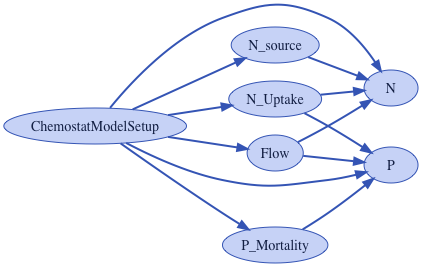

In [8]:
chemostat.visualize()

In [28]:
in_ds = xs.create_setup(
     model=chemostat,
     clocks={
         'time': np.linspace(0., 100., 1000)
     },
     master_clock='time',
     input_vars={
         'ChemostatModelSetup':{
             # P params
             'P_num':15,
             'P_initVal':1,
             'halfsat_min':.2,
             'halfsat_max':1.2,
             'mortality':0.,
             # N params
             'N_initVal':1
         },
         # additional processes
         'Flow__flowrate':0.1,
         'N_source__nutrient_influx':0.
     },
     output_vars={
        'P__state': 'time',
        'N__state': 'time'
     }
 )

In [29]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    with chemostat:
        out_ds = in_ds.xsimlab.run()

██████████ 100% | Simulation finished in 00:02 


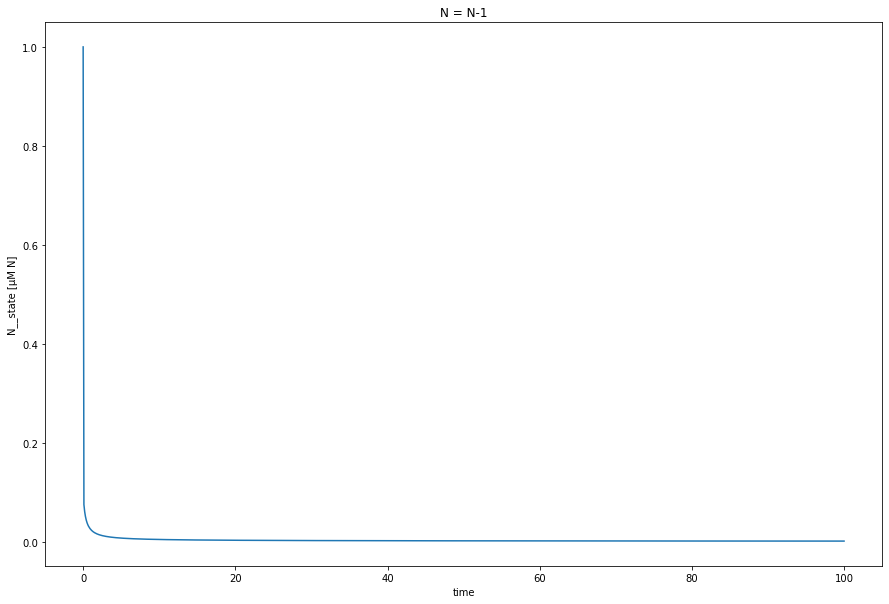

In [30]:
out_ds.N__state.plot()

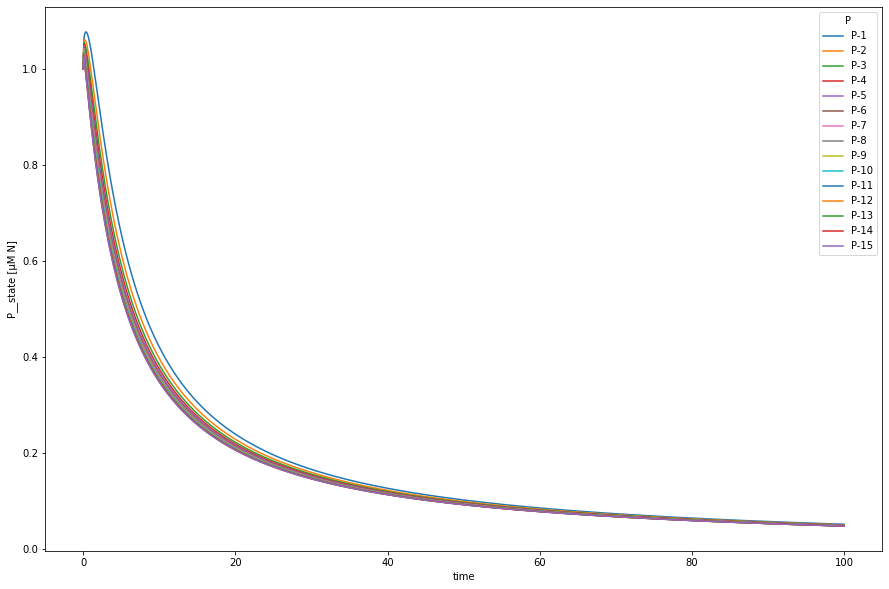

In [31]:
out_ds.P__state.plot.line(x='time')

# not suprisingly, one phytoplankton type wins out in the end, outcompeting all other types..
## predictably this is the type with the lowest half-saturation constant. 
(P-1 in this case, the halfsat parameter range is initialized in an increasing order)

This is unsurprising given the simple model structure and parameterization, but model results can be made much more interesting by including grazers and other pocesses that create further competition between phytoplankton types.